#### Initial Setup

In [2]:
#imported libraries
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import boto
import numpy as np
from numpy import matlib
import scipy as sp
import math
import matplotlib.pyplot as plt
import langdetect
import datetime
%matplotlib inline  
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import Imputer

import os
import findspark; findspark.init()
import pyspark
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql.types import Row
import pyspark.sql.functions as func
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.util import MLUtils

from pyspark.mllib.linalg import Vectors 
from pyspark.mllib.regression import LabeledPoint  
from pyspark.mllib.regression import LinearRegressionWithSGD 

os.environ["PYSPARK_SUBMIT_ARGS"] = (
  "--packages com.databricks:spark-csv_2.11:1.4.0 pyspark-shell"
)

#NEED TO ADD "  SPARK_DRIVER_MEMORY=5G   "  to ./conf/spark-env.sh 

try:
    conf = SparkConf().set("spark.executor.memory", "3g")
    sc = pyspark.SparkContext(conf=conf)
except Exception as e:
    print "SparkContext exists... Continuing on."
    
sqlCtx = pyspark.sql.SQLContext(sc)
sc.setCheckpointDir('checkpoint/')

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Load files

In [7]:
try:
    sc._jsc.hadoopConfiguration().set("fs.s3n.awsAccessKeyId", os.environ['AWS_ACCESS_KEY_ID'])
    sc._jsc.hadoopConfiguration().set("fs.s3n.awsSecretAccessKey", os.environ['AWS_SECRET_ACCESS_KEY'])
    downloads = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/train_app_downloads.csv').drop('')
    ratings = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/train_app_rating.csv').drop('')
    usages = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/train_usage.csv').drop('')
    revenues = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/train_revenue.csv').drop('')
    output = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/train_final_downloads.csv').drop('')
    prev_downloads = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/train_cumulative_downloads_2015-02.csv').drop('')  
    release_date = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/train_release_date.csv').drop('')
    text_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='false',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/sentiment.csv').drop('')
    title_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='false',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/t_sentiment.csv').drop('')
    avg_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/avg_sent_score.csv').drop('')
    rating_country = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('s3n://cs341bucket1/Data/train_rating_by_country.csv').drop('')

    reviews_schema = StructType([
        StructField("id",IntegerType(),True),
        StructField("name",StringType(),True),
        StructField("country",StringType(),True),
        StructField("rating",IntegerType(),True),
        StructField("date",StringType(),True),
        StructField("title",StringType(),True),
        StructField("version",StringType(),True),
        StructField("text",StringType(),True),
        StructField("reviewer",StringType(),True)
    ])
    reviews = pd.read_csv('s3://cs341bucket1/Data/train_app_review.csv')
    reviews = sqlCtx.createDataFrame(reviews,reviews_schema)
except:
    downloads = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_app_downloads.csv').drop('')
    ratings = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_app_rating.csv').drop('')
    usages = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_usage.csv').drop('')
    revenues = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_revenue.csv').drop('')
    output = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_final_downloads.csv').drop('')
    prev_downloads = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_cumulative_downloads_2015-02.csv').drop('')  
    release_date = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_release_date.csv').drop('')
    text_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='false',inferSchema='true') \
        .load('sentiment.csv').drop('')
    title_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='false',inferSchema='true') \
        .load('t_sentiment.csv').drop('')
    avg_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('avg_sent_score.csv').drop('')
    rating_country = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_rating_by_country.csv').drop('')

    reviews_schema = StructType([
        StructField("id",IntegerType(),True),
        StructField("name",StringType(),True),
        StructField("country",StringType(),True),
        StructField("rating",IntegerType(),True),
        StructField("date",StringType(),True),
        StructField("title",StringType(),True),
        StructField("version",StringType(),True),
        StructField("text",StringType(),True),
        StructField("reviewer",StringType(),True)
    ])
    reviews = pd.read_csv('train_app_review.csv')
    reviews = sqlCtx.createDataFrame(reviews,reviews_schema)

#try:
#    sc._jsc.hadoopConfiguration().set("fs.s3n.awsAccessKeyId", os.environ['AWS_ACCESS_KEY_ID'])
#    sc._jsc.hadoopConfiguration().set("fs.s3n.awsSecretAccessKey", os.environ['AWS_SECRET_ACCESS_KEY'])
downloads = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('C:\\Users/andre/Documents/StanfordMS/CS 341/Data/train_app_downloads.csv').drop('')
ratings = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\train_app_rating.csv').drop('')
usages = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\train_usage.csv').drop('')
revenues = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\train_revenue.csv').drop('')
output = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\train_final_downloads.csv').drop('')
prev_downloads = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\train_cumulative_downloads_2015-02.csv').drop('')
release_date = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\train_release_date.csv').drop('')
text_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='false',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\sentiment.csv').drop('')
title_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='false',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\t_sentiment.csv').drop('')
avg_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\avg_sent_score.csv').drop('')

reviews_schema = StructType([
        StructField("id",IntegerType(),True),
        StructField("name",StringType(),True),
        StructField("country",StringType(),True),
        StructField("rating",IntegerType(),True),
        StructField("date",StringType(),True),
        StructField("title",StringType(),True),
        StructField("version",StringType(),True),
        StructField("text",StringType(),True),
        StructField("reviewer",StringType(),True)
    ])
reviews = pd.read_csv('C:\\Users\\andre\\Documents\\StanfordMS\\CS 341\\Data\\train_app_review.csv')
reviews = sqlCtx.createDataFrame(reviews,reviews_schema)
'''except:
    downloads = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_app_downloads.csv').drop('')
    ratings = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_app_rating.csv').drop('')
    usages = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_usage.csv').drop('')
    revenues = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_revenue.csv').drop('')
    output = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_final_downloads.csv').drop('')
    prev_downloads = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_cumulative_downloads_2015-02.csv').drop('')  
    release_date = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('train_release_date.csv').drop('')
    text_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='false',inferSchema='true') \
        .load('sentiment.csv').drop('')
    title_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='false',inferSchema='true') \
        .load('t_sentiment.csv').drop('')
    avg_score = sqlCtx.read \
        .format('com.databricks.spark.csv') \
        .options(header='true',inferSchema='true') \
        .load('avg_sent_score.csv').drop('')

    reviews_schema = StructType([
        StructField("id",IntegerType(),True),
        StructField("name",StringType(),True),
        StructField("country",StringType(),True),
        StructField("rating",IntegerType(),True),
        StructField("date",StringType(),True),
        StructField("title",StringType(),True),
        StructField("version",StringType(),True),
        StructField("text",StringType(),True),
        StructField("reviewer",StringType(),True)
    ])
    reviews = pd.read_csv('train_app_review.csv')
    reviews = sqlCtx.createDataFrame(reviews,reviews_schema)'''

In [19]:
#usage imputation
imputer = Imputer(missing_values=-1, strategy='median', axis=0)
pd_usages = usages.toPandas()
category = list(set(pd_usages["category"].values))
imp = pd.DataFrame(columns = pd_usages.columns)
for cat in category:
    #for dev in ["iphone","ipad"]:
        for metric in range(1,5):
            curr_df = pd_usages.ix[pd_usages["category"]==cat,:]
            #curr_df = curr_df.ix[curr_df["device"]==dev,:]
            curr_df = curr_df.ix[curr_df["metric"]==metric,:]
            name = curr_df.columns
            df1 = curr_df.ix[:,0:6]
            df2 = pd.DataFrame(imputer.fit_transform(curr_df.ix[:,6:]))
            df2.index = df1.index
            curr_df = pd.concat([df1,df2],axis = 1)
            curr_df.columns = name 
            imp = pd.concat([imp,curr_df],axis = 0)
usages = sqlCtx.createDataFrame(imp)

#revenue imputation
pd_revenues = revenues.toPandas()
imp = pd.DataFrame(columns = revenues.columns)
for cat in category:
    for dev in ["iphone","ipad"]:
        #for metric in range(1,5):
            curr_df = pd_revenues.ix[pd_revenues["category"]==cat,:]
            curr_df = curr_df.ix[curr_df["device"]==dev,:]
            #curr_df = curr_df.ix[curr_df["metric"]==metric,:]
            name = curr_df.columns
            df1 = curr_df.ix[:,0:5]
            df2 = pd.DataFrame(imputer.fit_transform(curr_df.ix[:,5:]))
            df2.index = df1.index
            curr_df = pd.concat([df1,df2],axis = 1)
            curr_df.columns = name 
            imp = pd.concat([imp,curr_df],axis = 0)
revenues = sqlCtx.createDataFrame(imp)



#### Generate Predictors

In [10]:
old_dateRange = pd.date_range('03/01/2015', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))
dateRange = pd.date_range('03/01/2015', periods=56).format(formatter=lambda x: x.strftime('%m_%d_%Y'))
for d in range(56):
    revenues = revenues.withColumnRenamed(old_dateRange[d],dateRange[d])
    usages = usages.withColumnRenamed(old_dateRange[d],dateRange[d])
    downloads = downloads.withColumnRenamed(old_dateRange[d],dateRange[d])  
output = output.withColumnRenamed("cumulative_downloads_2016-02","cumulative_downloads_2016_02")
prev_downloads = prev_downloads.withColumnRenamed("cumulative_downloads_2015-02","cumulative_downloads_2015_02")

In [21]:
#Initialization
predictors = downloads['id','name','category','device']

In [22]:
# Generate the weekly downloads

sqlCtx.registerDataFrameAsTable(downloads, "downloads")
sqlCtx.registerDataFrameAsTable(usages, "usages")
sqlCtx.registerDataFrameAsTable(revenues, "revenues")

def get_log_week(*args):
    args = [x if not (x<0) else 0 for x in list(args)]
    nb_0 = args.count(0)
    if nb_0 == 7:
        return float(0)
    return math.log(1.0*sum(args)/(7-nb_0))
    #Y = [np.log(c) for c in args if c > 0]
    #if len(Y) == 0 : return 0
    #return float(1.0*sum(Y))/(7-nb_0)
sqlCtx.registerFunction("get_log_week", get_log_week,returnType=FloatType())
def get_download_sum(*args):
    args = [x if not (x==-1) else 0 for x in list(args)]
    return (1.0*sum(args))
sqlCtx.registerFunction("get_download_sum", get_download_sum,returnType=FloatType())

predictors = sqlCtx.sql("SELECT id, name, category, device, \
           get_log_week("+ ",".join(dateRange[0:7])+") AS week_1 \
            ,get_log_week("+",".join(dateRange[7:14])+") AS week_2 \
            ,get_log_week("+ ",".join(dateRange[14:21])+") AS week_3 \
           ,get_log_week("+",".join(dateRange[21:28])+") AS week_4 \
           ,get_log_week("+",".join(dateRange[28:35])+") AS week_5 \
           ,get_log_week("+",".join(dateRange[35:42])+") AS week_6 \
           ,get_log_week("+",".join(dateRange[42:49])+") AS week_7 \
           ,get_log_week("+",".join(dateRange[49:56])+") AS week_8\
           ,get_download_sum("+ ",".join(dateRange)+") AS download_sum \
           from downloads")
sqlCtx.registerDataFrameAsTable(predictors, "predictors")

#I workaround the error by this modification. 
#I don't know why I couldn't run the code before but this workaround gives the same result.
#predictors = sqlCtx.sql("SELECT "+', '.join(predictors.columns)+", week_1+week_2+week_3+week_4+week_5+week_6+week_7+week_8 AS download_sum FROM predictors")


In [23]:
m1 = sqlCtx.sql("SELECT * FROM usages WHERE metric = 1")
m2 = sqlCtx.sql("SELECT * FROM usages WHERE metric = 2")
m3 = sqlCtx.sql("SELECT * FROM usages WHERE metric = 3")
m4 = sqlCtx.sql("SELECT * FROM usages WHERE metric = 4")
sqlCtx.registerDataFrameAsTable(m1,"m1")
sqlCtx.registerDataFrameAsTable(m2,"m2")
sqlCtx.registerDataFrameAsTable(m3,"m3")
sqlCtx.registerDataFrameAsTable(m4,"m4")
sqlCtx.registerDataFrameAsTable(avg_score,"avg_score")

In [24]:
# Make coefficients

def get_coefficients(*args):
    #The first element of the list is the degree of the coefficient
    args = [x if not (x==-1) else 0 for x in list(args)]    
    return  float(np.polyfit(range(56),np.cumsum(args[1:]),args[0])[0])
    #Y = [np.log(c) for c in args[1:] if c>0]
    #if len(Y)<=1: return float(0)
    #return  float(np.polyfit(range(len(Y)),np.cumsum(Y),args[0])[0])
    
#Generate the step max and min 
def get_maxStep(maximum,*args):
    args = [x if not (x==-1) else 0 for x in list(args)]
    if (np.count_nonzero(args) == 0):
        return float(0)
    if maximum :
        return max(args)
    else:
        return min(filter(lambda x: x>0,args))

    
def get_maxStep_old(maximum,*args):
    args = [x if not (x==-1) else 0 for x in list(args)]
    m = 0
    for d in range(1,56):
        if (args[d]!=0 and args[d-1]!=0):
            c = (args[d]-args[d-1])
            #c = float(args[d])/args[d-1]
            if (maximum and m < c):
                m = c
            if ( not maximum and m > c):
                m = c
    return m
    #if m==0: return float(0)
    #return m

def get_std(*args):
    args = [x if not (x==-1) else 0 for x in list(args)]
    return float(np.std(list(args)))

def get_nbMissing(*args):
    return list(args).count(-1)

#Generate the daily average

def get_revenue_coefficients(*args):
    #The first element of the list is the degree of the coefficient
    args = list(args)
    time_series = [np.log(c) for c in args[1:] if c>0]
    if len(time_series) <=1: return float(0)
    #return float(np.polyfit(np.array(range(56)),args[1:],args[0])[0])
    return  float(np.polyfit(np.array(range(len(time_series))),time_series,args[0])[0])

def get_usage_coefficients(*args):
    #The first element of the list is the degree of the coefficient
    args = list(args)
    if -1 in args: return 0
    return  float(np.polyfit(range(8),args[1:],args[0])[0])

def get_usage_max(*args):
    #The first element of the list is the degree of the coefficient
    args = list(args)
    args = [c for c in args[1:] if c!=-1]
    if len(args)==0: return 0
    return  float(np.max(args))

def get_usage_mean(*args):
    #The first element of the list is the degree of the coefficient
    args = list(args)
    args = [c for c in args[1:] if c!=-1]
    if len(args)==0: return 0
    return  float(np.mean(args))

def get_revenue_max(*args):
    #The first element of the list is the degree of the coefficient
    args = list(args)
    time_series = [np.log(c) for c in args[1:] if c>0]
    if len(time_series) <=1: return float(0)
    #args = [c for c in args[1:] if c!=-1]
    #if len(args)==0: return 0
    #return  float(np.max(args))
    return float(np.max(time_series))

def get_revenue_mean(*args):
    #The first element of the list is the degree of the coefficient
    args = list(args)
    #args = [c for c in args[1:] if c!=-1]
    #if len(args)==0: return 0
    #return  float(np.mean(args))
    time_series = [np.log(c) for c in args[1:] if c>0]
    if len(time_series) <=1: return float(0)
    return float(np.mean(time_series))

def get_dailyAvg(*args):
    args = [x if not (x==-1) else 0 for x in list(args)]
    if (np.count_nonzero(args) == 0):
        return float(0)
    return  (1.0*sum(args)/np.count_nonzero(args))
    #return float(sum([np.log(c) for c in args if c>0]))/np.count_nonzero(args)

sqlCtx.registerFunction("get_nbMissing", get_nbMissing,returnType=IntegerType())
sqlCtx.registerFunction("get_std", get_std,returnType=FloatType())
sqlCtx.registerFunction("get_maxStep", get_maxStep,returnType=IntegerType())
sqlCtx.registerFunction("get_maxStep_old", get_maxStep_old,returnType=FloatType())
sqlCtx.registerFunction("get_coefficients", get_coefficients,returnType=FloatType())
sqlCtx.registerFunction("daily_avg", get_dailyAvg,returnType=FloatType())
sqlCtx.registerFunction("get_usage_coefficients", get_usage_coefficients,returnType=FloatType())
sqlCtx.registerFunction("get_revenue_coefficients", get_revenue_coefficients,returnType=FloatType())
sqlCtx.registerFunction("get_usage_max", get_usage_max,returnType=FloatType())
sqlCtx.registerFunction("get_usage_mean", get_usage_mean,returnType=FloatType())
sqlCtx.registerFunction("get_revenue_max", get_revenue_max,returnType=FloatType())
sqlCtx.registerFunction("get_revenue_mean", get_revenue_mean,returnType=FloatType())

temp_downloads = sqlCtx.sql("SELECT id,name,category, device \
, get_coefficients(0,"+",".join(dateRange)+") AS coef_0 \
,get_coefficients(1,"+",".join(dateRange)+") AS coef_1 \
,get_coefficients(2,"+",".join(dateRange)+") AS coef_2 \
,get_coefficients(3,"+",".join(dateRange)+") AS coef_3 \
,get_maxStep(True,"+",".join(dateRange)+") AS max_step \
,get_maxStep(False,"+",".join(dateRange)+") AS min_step \
,get_maxStep_old(True,"+",".join(dateRange)+") AS max_step_old \
,get_maxStep_old(False,"+",".join(dateRange)+") AS min_step_old \
,get_std("+",".join(dateRange)+") AS downloads_std \
,get_nbMissing("+",".join(dateRange)+") AS nb_missing \
,daily_avg(" + ",".join(dateRange[0:56]) + ") AS daily_avg \
 FROM downloads")

predictors = predictors.join(temp_downloads,["id","name","category","device"],how='left_outer')

temp_m1 = sqlCtx.sql("SELECT id, name, category, device, \
get_usage_coefficients(0,"+",".join(m1.columns[5:13])+") AS m1_coef_0, \
get_usage_coefficients(1,"+",".join(m1.columns[5:13])+") AS m1_coef_1, \
get_usage_coefficients(2,"+",".join(m1.columns[5:13])+") AS m1_coef_2, \
get_usage_max(0,"+",".join(m1.columns[5:13])+") AS m1_max, \
get_usage_mean(0,"+",".join(m1.columns[5:13])+") AS m1_mean FROM m1")

temp_m2 = sqlCtx.sql("SELECT id, name, category, device, \
get_usage_coefficients(0,"+",".join(m2.columns[5:13])+") AS m2_coef_0, \
get_usage_coefficients(1,"+",".join(m2.columns[5:13])+") AS m2_coef_1, \
get_usage_coefficients(2,"+",".join(m2.columns[5:13])+") AS m2_coef_2, \
get_usage_max(0,"+",".join(m2.columns[5:13])+") AS m2_max, \
get_usage_mean(0,"+",".join(m2.columns[5:13])+") AS m2_mean FROM m2")

temp_m3 = sqlCtx.sql("SELECT id, name, category, device, \
get_usage_coefficients(0,"+",".join(m3.columns[5:13])+") AS m3_coef_0, \
get_usage_coefficients(1,"+",".join(m3.columns[5:13])+") AS m3_coef_1, \
get_usage_coefficients(2,"+",".join(m3.columns[5:13])+") AS m3_coef_2, \
get_usage_max(0,"+",".join(m3.columns[5:13])+") AS m3_max, \
get_usage_mean(0,"+",".join(m3.columns[5:13])+") AS m3_mean FROM m3")

temp_m4 = sqlCtx.sql("SELECT id, name, category, device, \
get_usage_coefficients(0,"+",".join(m4.columns[5:13])+") AS m4_coef_0, \
get_usage_coefficients(1,"+",".join(m4.columns[5:13])+") AS m4_coef_1, \
get_usage_coefficients(2,"+",".join(m4.columns[5:13])+") AS m4_coef_2, \
get_usage_max(0,"+",".join(m4.columns[5:13])+") AS m4_max, \
get_usage_mean(0,"+",".join(m4.columns[5:13])+") AS m4_mean FROM m4")

temp_revenues = sqlCtx.sql("SELECT id, name, category, device, \
get_revenue_coefficients(0,"+",".join(revenues.columns[4:])+") AS rev_coef_0, \
get_revenue_coefficients(1,"+",".join(revenues.columns[4:])+") AS rev_coef_1, \
get_revenue_coefficients(2,"+",".join(revenues.columns[4:])+") AS rev_coef_2, \
get_revenue_max(0,"+",".join(revenues.columns[4:])+") AS rev_max, \
get_revenue_mean(0,"+",".join(revenues.columns[4:])+") AS rev_mean FROM revenues")


predictors = predictors.join(temp_revenues,["id", "name", "category","device"],how='left_outer')
predictors = predictors.join(temp_m1,["id", "name", "category","device"],how='left_outer')
predictors = predictors.join(temp_m2,["id", "name", "category","device"],how='left_outer')
predictors = predictors.join(temp_m3,["id", "name", "category","device"],how='left_outer')
predictors = predictors.join(temp_m4,["id", "name", "category","device"],how='left_outer')
predictors = predictors.join(avg_score,["id", "name", "category","device"],how='left_outer')
#predictors = predictors.join(temp_usages,["id", "name", "category","device"],how='left_outer')
#predictors = predictors.join(,)



In [25]:
# previous downloads addition
predictors = predictors.join(prev_downloads,["id","device"],how='left_outer')

In [26]:
# Days since release generation with imputation
def get_days(date, id):
    if (date == "no_date") or True:   #Attention here, only imputation
        # return 0
        id = 1.0*id/100000000
        return int(5856.25394104 -1731.74798728*id+195.553086*id**2  -8.12861635*id**3)
    else:
        try:
            return (datetime.datetime.strptime('03/01/2015', '%m/%d/%Y').date() \
                - datetime.datetime.strptime(date, '%m/%d/%Y').date()).days
        except:
            return (datetime.datetime.strptime('03/01/2015', '%m/%d/%Y').date() \
                - datetime.datetime.strptime(date, '%Y-%m-%d').date()).days



release_date = downloads[["id"]].dropDuplicates().join(release_date,["id"],"left").fillna("no_date",["release_date"])
sqlCtx.registerDataFrameAsTable(release_date, "release_date")
sqlCtx.registerFunction("get_days", get_days,returnType=IntegerType())
temp_date = sqlCtx.sql("SELECT id\
, get_days(release_date, id) AS days_since_release \
 FROM release_date")

predictors = predictors.join(temp_date,["id"],"left")

In [27]:
#ratings generation
sqlCtx.registerDataFrameAsTable(ratings, "ratings")
temp_ratings = sqlCtx.sql("SELECT id,name,category \
, CAST(1.0*start1/(start1+star2+star3+star4+star5) AS float) AS star1 \
, CAST(1.0*star2/(start1+star2+star3+star4+star5) AS float) AS star2 \
, CAST(1.0*star3/(start1+star2+star3+star4+star5) AS float) AS star3 \
, CAST(1.0*star4/(start1+star2+star3+star4+star5) AS float) AS star4 \
, CAST(1.0*star5/(start1+star2+star3+star4+star5) AS float) AS star5 \
, (start1+star2+star3+star4+star5) AS num_ratings \
 FROM ratings")

predictors = predictors.join(temp_ratings,["id","name","category"],"left")

In [28]:
# Categories
list_categories = [ x.category.replace(" ","_") for x in sqlCtx.sql("SELECT category \
 FROM downloads\
 group by category \
 ").collect()]
for cat in list_categories:
    sqlCtx.registerDataFrameAsTable(predictors, "predictors")
    predictors=sqlCtx.sql('''SELECT *, CASE WHEN (category = "'''+cat+'''") THEN 1 ELSE 0 END AS '''+cat+''' FROM predictors''')


In [29]:
# Device
sqlCtx.registerDataFrameAsTable(predictors, "predictors")
predictors=sqlCtx.sql('''SELECT *, CASE WHEN (device = "iphone") THEN 1 ELSE 0 END AS iphone FROM predictors''')
sqlCtx.registerDataFrameAsTable(predictors, "predictors")
#predictors=sqlCtx.sql('''SELECT *, CASE WHEN (device = "ipad") THEN 1 ELSE 0 END AS ipad FROM predictors''')

In [30]:
lang = ['ja','zh-cn','ko','en','other']
def get_language(x):
    try:
        detected = langdetect.detect_langs(x.decode('utf8','ignore'))[0]
        if detected.prob < 0.7:
            return "other"
        elif  detected.lang in lang:
            return detected.lang
        else:
            return "other"
    except:
        return "other"
sqlCtx.registerFunction("get_language", get_language,returnType=StringType())

In [31]:
#Language of the title
for l in lang:
    sqlCtx.registerDataFrameAsTable(predictors, "predictors")
    predictors=sqlCtx.sql('''SELECT *, CASE WHEN (get_language(name) = "'''+l+'''") THEN 1 \
    ELSE 0 END AS '''+l.replace("-","_")+''' FROM predictors''')

In [32]:
#Reviews 
#escape is used in case some asshole used - or [space] anywhere
def escape(text):
    return text.replace(" ","_").replace("-","_")
# number of reviews
def get_recentReviews(date):
    return int((datetime.datetime.strptime('04/01/2015', '%m/%d/%Y').date() \
            - datetime.datetime.strptime(date, '%Y-%m-%d').date()).days >=0)

#First step
list_countries =['United_States', 'France', 'Japan', 'Spain', 'United_Kingdom','Saudi_Arabia', 'Germany'\
     , 'Hong_Kong', 'Switzerland', 'Turkey','Netherlands', 'Australia', 'Norway', 'Sweden', 'China', 'Canada'\
     ,'Tanzania', 'Denmark', 'South_Korea', 'Italy', 'Finland', 'Taiwan','Russia', 'Philippines', 'Slovenia'\
     , 'Ireland', 'Belgium', 'Mexico','Austria', 'India', 'Brazil', 'Benin', 'New_Zealand','United_Arab_Emirates'\
     , 'Ukraine', 'Poland', 'Israel', 'Portugal','Tunisia', 'Mali', 'Slovakia', 'Zimbabwe', 'Thailand', 'Panama'\
     ,'Indonesia', 'Singapore', 'Greece', 'Senegal', 'Nicaragua','Hungary', 'Czech_Republic', 'Macedonia', 'Chile'\
     , 'Uruguay','Malaysia', 'Algeria', 'Nepal', 'Mauritania', 'Croatia']

cmd = '''review_rdd = reviews\
.map(lambda x : (x.id , Row(id = x.id , avg_review = x.rating \
, recent_review = get_recentReviews(x.date), nb_review = 1\
,version = set([x.version])'''
cmd+=",country = set([x.country])"
#for c in list_countries:
#    cmd+=","+c+''' = int( escape(x.country) == "'''+c+'''")'''
for i in range(1,6):
    cmd+=",review_rating_"+str(i)+" = int(x.rating == "+str(i)+")  "
cmd+=")))"
exec cmd

#Group step
cmd = '''review_rdd = review_rdd.reduceByKey(lambda x1 ,x2 : Row(\
 avg_review = x1.avg_review + x2.avg_review\
   ,recent_review = x1.recent_review + x2.recent_review, nb_review = x1.nb_review + x2.nb_review'''
#for c in list_countries:
#    cmd+=" , "+c+" = x1."+c+" + x2."+c
cmd+=", country = x1.country.union(x2.country)"
cmd+=", version = x1.version.union(x2.version)"
for i in range(1,6):
    cmd+=", review_rating_"+str(i)+" = x1.review_rating_"+str(i)+" + x2.review_rating_"+str(i)+" "
cmd+="))"
exec cmd

# Clean the grouped rdd
cmd = '''review_rdd = review_rdd.map(lambda (id , x) : [ id \
,  1.0*x.avg_review /  x.nb_review\
   , x.recent_review,  x.nb_review'''
#for c in list_countries:
#    cmd+=" , 1.0* x."+c+"/ x.nb_review"
cmd+=",  escape(x.country.pop())"
cmd+=",  len(x.version) -1 " # -1 if want number of updates
for i in range(1,6):
    cmd+=", 1.0*x.review_rating_"+str(i)+" / x.nb_review"
cmd+="])"
exec cmd

#Put back into dataframe
grp_reviews = sqlCtx.createDataFrame(review_rdd, ["id","avg_review"\
      ,"recent_reviews","nb_reviews","country","versions"]+["review_rating_"+str(i) for i in range(1,6)])
    #,"recent_reviews","nb_reviews"] + list_countries + ["versions"]+["review_rating_"+str(i) for i in range(1,6)])
    
#Join with predictors 
predictors = predictors.join(grp_reviews,["id"],"left").fillna("no_country",["country"])

In [33]:
# Generate DL Projection
sqlCtx.registerDataFrameAsTable(predictors, "predictors")
derived_feats = sqlCtx.sql("SELECT id, device\
    ,(7*download_sum+cumulative_downloads_2015_02) AS dl_projection \
    ,CAST((1000000.0*num_ratings/(cumulative_downloads_2015_02 + download_sum))AS float )  AS ratings_per_downloads \
    ,CAST((1.0*num_ratings/(days_since_release+56))AS float )  AS ratings_per_day \
    ,CAST((1000000.0*nb_reviews/download_sum)AS float )  AS review_per_downloads \
    ,CAST((1.0*recent_reviews/nb_reviews)AS float )  AS review_recent_over_old \
    ,CAST((1.0*nb_reviews / days_since_release)AS float )  AS review_per_day \
    ,CAST((1.0*cumulative_downloads_2015_02/(days_since_release))AS float )  AS downloads_per_day_before \
    ,CAST(1.0*download_sum/cumulative_downloads_2015_02 AS float ) AS relative_download_increase\
    ,CAST(1.0*nb_reviews / (CASE WHEN (days_since_release<56) THEN days_since_release ELSE 56 END) AS float) AS reviews_per_days\
    ,CAST(7*download_sum+cumulative_downloads_2015_02 / days_since_release / days_since_release AS float) AS down_over_days2\
    FROM predictors")
predictors = predictors.join(derived_feats,["id","device"],"left")

In [34]:


#we could group by continent or use the market potential
list_countries+=["no_country"]
for co in list_countries:
    sqlCtx.registerDataFrameAsTable(predictors, "predictors")
    predictors=sqlCtx.sql('''SELECT *, CASE WHEN (country = "'''+co+'''") THEN 1 ELSE 0 END AS '''+co+''' FROM predictors''')
def get_market(country,device):
    #http://blog.nelso.com/2010/06/iphone-os-penetration-by-country.html
    if device == "iphone":
        return {
            "United_States" : 10683403,
            "France" : 2248817,
            "Japan" : 1378903,
            "Spain" : 377346,
            "United_Kingdom" : 2551128,
            "Germany" : 1117716,
            "Hong_Kong" : 299720,
            "Switzerland" : 399364,
            "Netherlands" : 372539,
            "Australia" : 1207428,
            "Norway" : 154218,
            "Sweden" : 281622,
            "China" : 725358,
            "Canada" : 919074,
            "Denmark" : 151426,
            "Italy" : 648718,
            "Taiwan" : 174226,
            "Mexico" : 215326,
            "Austria" : 156322,
            "Brazil" : 219339,
            "Poland" : 72114,
            "Singapore" : 402922,
            "Hungary" : 33219,
            "Czech_Republic" : 42753,
            'South_Korea': 530235,
            "Russia" :246421   
    }.get(country, 15000) 
    else:
        return{
            "United_States" : 223269,
            "France" : 2724,
            "Japan" : 2293,
            "Spain" : 1494,
            "United_Kingdom" : 4197,
            "Germany" : 3403,
            "Hong_Kong" : 2306,
            "Switzerland" : 1698,
            "Netherlands" : 2554,
            "Australia" : 1400,
            "Norway" : 1333,
            "Sweden" : 1188,
            "China" : 12516,
            "Canada" : 6275,
            "Denmark" : 753,
            "Italy" : 1370,
            "Taiwan" : 1356,
            "Mexico" : 3380,
            "Austria" : 493,
            "Brazil" : 2014,
            "Poland" : 324,
            "Singapore" : 1453,
            "Hungary" : 211,
            "Czech_Republic" : 203,
            'South_Korea': 2416,
            "Russia" :2183
        }.get(country, 100) 
    
    
    return 1
sqlCtx.registerFunction("get_market", get_market,returnType=IntegerType())

sqlCtx.registerDataFrameAsTable(predictors, "predictors")
predictors=sqlCtx.sql('''SELECT *, get_market(country,device) AS market_size FROM predictors''')

In [35]:
sqlCtx.registerDataFrameAsTable(rating_country, "rating_country")
rating_country = sqlCtx.sql('SELECT id\
, CAST(SUM(star1)*1.0/(SUM(star1)+SUM(star2)+SUM(star3)+SUM(star4)+SUM(star5)) AS float) AS total_star1\
, CAST(SUM(star2)*1.0/(SUM(star1)+SUM(star2)+SUM(star3)+SUM(star4)+SUM(star5)) AS float)AS total_star2\
, CAST(SUM(star3)*1.0/(SUM(star1)+SUM(star2)+SUM(star3)+SUM(star4)+SUM(star5))AS float) AS total_star3\
, CAST(SUM(star4)*1.0/(SUM(star1)+SUM(star2)+SUM(star3)+SUM(star4)+SUM(star5))AS float) AS total_star4\
, CAST(SUM(star5)*1.0/(SUM(star1)+SUM(star2)+SUM(star3)+SUM(star4)+SUM(star5)) AS float)AS total_star5\
, (SUM(star1)+SUM(star2)+SUM(star3)+SUM(star4)+SUM(star5)) AS total_star\
, COUNT(1) AS nb_countries FROM rating_country GROUP BY id')

sqlCtx.registerDataFrameAsTable(rating_country, "rating_country")

predictors = predictors.join(rating_country,["id"],how='left_outer')

In [36]:
sqlCtx.registerDataFrameAsTable(predictors, "predictors")
cmd = 'SELECT * '
for i in range(1,6):
    cmd+=',(total_star'+str(i)+' * total_star / cumulative_downloads_2015_02) AS country_star'+str(i)+'_per_downloads '
    cmd+=',(review_rating_'+str(i)+' * nb_reviews / download_sum) AS review_star'+str(i)+'_per_downloads '
    cmd+=',(star'+str(i)+' * num_ratings / cumulative_downloads_2015_02) AS rating_star'+str(i)+'_per_downloads '
cmd+= ' FROM predictors'

predictors = sqlCtx.sql(cmd)

In [37]:
sqlCtx.registerDataFrameAsTable(predictors, "predictors")

predictors = sqlCtx.sql('SELECT *, CAST((max_step - min_step)*1.0/download_sum AS float) AS relative_step\
, (max_step - min_step)  AS download_step \
FROM predictors')

In [38]:
'''#Taking the log
to_log = ["download_sum","cumulative_downloads_2015_02","dl_projection"]
def get_log(x) : 
    try:
        return math.log(x)
    except:
        return 0
sqlCtx.registerFunction("get_log", get_log,returnType=FloatType())

for name in to_log:
    cmd = 'SELECT '+','.join(filter(lambda x : x not in  to_log ,predictors.columns))
    for t in to_log:
        cmd+= " , get_log("+t+") AS "+t
    cmd+=" FROM predictors"
    sqlCtx.registerDataFrameAsTable(predictors, "predictors")
    predictors=sqlCtx.sql(cmd)'''

'#Taking the log\nto_log = ["download_sum","cumulative_downloads_2015_02","dl_projection"]\ndef get_log(x) : \n    try:\n        return math.log(x)\n    except:\n        return 0\nsqlCtx.registerFunction("get_log", get_log,returnType=FloatType())\n\nfor name in to_log:\n    cmd = \'SELECT \'+\',\'.join(filter(lambda x : x not in  to_log ,predictors.columns))\n    for t in to_log:\n        cmd+= " , get_log("+t+") AS "+t\n    cmd+=" FROM predictors"\n    sqlCtx.registerDataFrameAsTable(predictors, "predictors")\n    predictors=sqlCtx.sql(cmd)'

In [39]:
predictors = predictors.fillna(0)

In [40]:
predictors.cache()

DataFrame[id: int, device: string, name: string, category: string, week_1: double, week_2: double, week_3: double, week_4: double, week_5: double, week_6: double, week_7: double, week_8: double, download_sum: double, coef_0: double, coef_1: double, coef_2: double, coef_3: double, max_step: int, min_step: int, max_step_old: double, min_step_old: double, downloads_std: double, nb_missing: int, daily_avg: double, rev_coef_0: double, rev_coef_1: double, rev_coef_2: double, rev_max: double, rev_mean: double, m1_coef_0: double, m1_coef_1: double, m1_coef_2: double, m1_max: double, m1_mean: double, m2_coef_0: double, m2_coef_1: double, m2_coef_2: double, m2_max: double, m2_mean: double, m3_coef_0: double, m3_coef_1: double, m3_coef_2: double, m3_max: double, m3_mean: double, m4_coef_0: double, m4_coef_1: double, m4_coef_2: double, m4_max: double, m4_mean: double, avg_sent_score: double, cumulative_downloads_2015_02: int, days_since_release: int, star1: double, star2: double, star3: double, st

In [41]:
predictors.toPandas().sort_values(by="id").fillna(0).to_csv("predictors_spark.csv", sep='\\',encoding='utf-8')

In [3]:
#to delete
predictors = sqlCtx.read \
    .format('com.databricks.spark.csv') \
    .options(header='true',inferSchema='true') \
    .load('predictors_spark.csv').drop('')

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## To Pandas


In [ ]:
output

In [5]:

predictors_pd = pd.read_csv('predictors_spark.csv',sep='\\').drop('Unnamed: 0', 1).fillna(0).sort_values(by="id")

In [97]:
predictors_pd = predictors.toPandas().sort_values(by="id").fillna(0)

In [23]:
predictors_pd = predictors_pd.sort_values(["id","device"])
output_pd = pd.merge(predictors_pd,output.toPandas(),on = ["id","device"],how="left")\
[["id","device", "cumulative_downloads_2016_02"]]

#predictors_pd["id"]=(predictors_pd["id"]).astype(str)+predictors_pd["device"]

numerical_predictors = list(predictors_pd.columns.values)
#numerical_predictors.remove("id");
numerical_predictors.remove("device");
numerical_predictors.remove("category");
numerical_predictors.remove("name");
numerical_predictors.remove("country");


#numerical_predictors.remove("downloads_std");
#numerical_predictors.remove("nb_missing");
#numerical_predictors.remove("max_step");

predictors_id = predictors_pd[["id","device"]].as_matrix()

predictors_matrix = predictors_pd[numerical_predictors].as_matrix()


#output_pd["id"]=(output_pd["id"]).astype(str)+output_pd["device"]
output_matrix = output_pd["cumulative_downloads_2016_02"].as_matrix()

#predictors_matrix

#This is the metric we use to determine our performance
def metric(y_pred,y_test,percent=1):
    top = int(len(y_pred)/100.0*percent)
    return (len(set([i[0] for i in sorted(enumerate(y_pred), key=lambda x:x[1],reverse=True)][0:top])
       .intersection([i[0] for i in sorted(enumerate(y_test), key=lambda x:x[1],reverse=True)][0:top])
               ))/(percent/100.0)/top

['id',
 'week_1',
 'week_2',
 'week_3',
 'week_4',
 'week_5',
 'week_6',
 'week_7',
 'week_8',
 'download_sum',
 'coef_0',
 'coef_1',
 'coef_2',
 'coef_3',
 'max_step',
 'min_step',
 'max_step_old',
 'min_step_old',
 'downloads_std',
 'nb_missing',
 'daily_avg',
 'rev_coef_0',
 'rev_coef_1',
 'rev_coef_2',
 'rev_max',
 'rev_mean',
 'm1_coef_0',
 'm1_coef_1',
 'm1_coef_2',
 'm1_max',
 'm1_mean',
 'm2_coef_0',
 'm2_coef_1',
 'm2_coef_2',
 'm2_max',
 'm2_mean',
 'm3_coef_0',
 'm3_coef_1',
 'm3_coef_2',
 'm3_max',
 'm3_mean',
 'm4_coef_0',
 'm4_coef_1',
 'm4_coef_2',
 'm4_max',
 'm4_mean',
 'avg_sent_score',
 'cumulative_downloads_2015_02',
 'days_since_release',
 'star1',
 'star2',
 'star3',
 'star4',
 'star5',
 'num_ratings',
 'Social_Networking',
 'Finance',
 'Books',
 'Business',
 'Newsstand',
 'Games',
 'Navigation',
 'News',
 'Music',
 'Weather',
 'Catalogs',
 'Health_and_Fitness',
 'Food_and_Drink',
 'Shopping',
 'Lifestyle',
 'Productivity',
 'Sports',
 'Reference',
 'Utilities',
 

In [ ]:
for c in [0.1,1.0,10,100,1000]:
    for e in [0.001,0.01,0.1,1.0,10,100,1000]:
        K = 5
        #print list(numerical_predictors)
        np.random.seed(4)
        kf = KFold(len(predictors_pd), n_folds=K,shuffle=True)
        new_top = []
        for train, test in kf:
            train_features = predictors_pd[numerical_predictors].as_matrix()[train,:]
            train_output = output_pd["cumulative_downloads_2016_02"].as_matrix()[train]

            test_features = predictors_pd[numerical_predictors].as_matrix()[test,:]
            test_output = output_pd["cumulative_downloads_2016_02"].as_matrix()[test]


            #mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=2, random_state=0, loss='ls')
            #mod = linear_model.Lasso(alpha=100)
            mod = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0\
                      , epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=100)
            mod.fit(train_features, train_output )
            y_pred = mod.predict(test_features)

            err = (metric(test_output,y_pred))
            new_top.append(err)
            #print err

        print "SVR for c= \t"+str(c)+" and e =\t "+str(e)+"  \t -->  "+str(1.0*sum(new_top)/len(new_top))

['week_1',
 'week_2',
 'week_3',
 'week_4',
 'week_5',
 'week_6',
 'week_7',
 'week_8',
 'daily_avg',
 'download_sum',
 'coef_0',
 'coef_1',
 'coef_2',
 'coef_3',
 'max_step_old',
 'min_step_old',
 'download_std',
 'nb_missing',
 'iphone',
 'ipad',
 'Productivity',
 'Entertainment',
 'Travel',
 'Sports',
 'Music',
 'Shopping',
 'Finance',
 'Business',
 'Navigation',
 'Food_and_Drink',
 'Utilities',
 'Newsstand',
 'Health_and_Fitness',
 'News',
 'Lifestyle',
 'Medical',
 'Weather',
 'Games',
 'Catalogs',
 'Social_Networking',
 'Photo_and_Video',
 'Reference',
 'Books',
 'Education',
 'ko',
 'other',
 'jp',
 'ch_zh',
 'en',
 'cumulative_downloads_2015_02',
 'dl_projection',
 'avg_review',
 'star1',
 'star2',
 'star3',
 'star4',
 'star5',
 'num_rating',
 'ratings_per_downloads',
 'versions',
 'nb_review',
 'review_per_downloads',
 'days_since_release',
 'downloads_per_day_before',
 'review_per_day',
 'ratings_per_day',
 'avg_sentiment',
 'm1_max',
 'm1_mean',
 'm1_coef_0',
 'm1_coef_1',
 

In [51]:
# The predictor pandas needs to be sorted by ascending ID

### Obtained with boosting feature selection
#numerical_predictors_2 = ['dl_projection','week_8','coef_2','week_5','downloads_per_day_before','cumulative_downloads_2015_02','week_7','downloads_std','coef_0','versions','download_sum','week_4','relative_download_increase','total_star3','days_since_release','market_size','week_3','review_rating_5','star3','review_rating_4','week_1','coef_1','m4_mean','review_rating_2','week_2','Uruguay','avg_review','nb_reviews']
#numerical_predictors_1 = ['dl_projection','week_8','coef_2','week_5','downloads_per_day_before','cumulative_downloads_2015_02','coef_3','versions','downloads_std','download_sum','days_since_release','m2_mean','coef_1','m1_mean','week_7','m2_coef_1','review_rating_5','week_6','review_recent_over_old','week_2','star4','coef_0','total_star3','m1_max','m3_max','star3','review_per_downloads','week_4','market_size','review_rating_4','week_3','nb_reviews','nb_missing','daily_avg','ratings_per_day']

###Custom
numerical_predictors_2 = ['download_sum', 'nb_reviews', 'iphone', 'Education']
numerical_predictors_1 = ['dl_projection', 'm3_max', 'week_8', 'coef_2', 'review_star5_per_downloads']

### Use all predictors
#numerical_predictors_2 = list(numerical_predictors)
#numerical_predictors_1 = list(numerical_predictors)

#Analysis on train performance if train > test this means there is overfit

with_rel = False
K = 5
for mu in ["nope"]:
    np.random.seed(1)

    split_fraction = 1.0*75/100
    kf = KFold(len(predictors_pd), n_folds=K,shuffle=True)
    new_top = []
    err_1 = []
    err_2 = []
    for train, test in kf:
        train_output = output_pd["cumulative_downloads_2016_02"].as_matrix()[train]


        train_features_1 = predictors_pd[numerical_predictors_1].as_matrix()[train,:]#[:int(split_fraction*len(train))]
        train_features_2 = predictors_pd[numerical_predictors_2].as_matrix()[train,:][int(split_fraction*len(train)):]
        train_output_1 = train_output#[:int(split_fraction*len(train))]
        train_output_2 = train_output[int(split_fraction*len(train)):]

        test_output = output_pd["cumulative_downloads_2016_02"].as_matrix()[test]

        test_features_1 = predictors_pd[numerical_predictors_1].as_matrix()[test,:][:int(split_fraction*len(test))]
        test_features_2 = predictors_pd[numerical_predictors_2].as_matrix()[test,:][int(split_fraction*len(test)):]
        test_output_1 = test_output[:int(split_fraction*len(test))]
        test_output_2 = test_output[int(split_fraction*len(test)):]

        if with_rel == True :
            threshold1_20 = sorted(train_output_1,reverse = True)[int(len(train_output_1)*20.0/100)]
            threshold1_12 = sorted(train_output_1,reverse = True)[int(len(train_output_1)*12.0/100)]
            threshold1_5 = sorted(train_output_1,reverse = True)[int(len(train_output_1)*5.0/100)]
            threshold1_1 = sorted(train_output_1,reverse = True)[int(len(train_output_1)*1.0/100)]
            threshold1_0 = 0.0

            relevance_1 =(range(len(train_features_1)))
            relevance_1.sort(key=lambda x: (train_output_1[x]))
            relevance_1 = (np.asarray(relevance_1)-int(99.0*len(train_features_1)/100))
            relevance_1[relevance_1<0] = 0

            mod_train_1 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,max_depth=2, random_state=0, loss='ls')\
            .fit(train_features_1,np.log(train_output_1))
            train_pred_1 =  mod_train_1.predict(train_features_1)

            pred_train_mask_1 = train_pred_1 > sorted(train_pred_1,reverse = True)[int(1.0/100*len(train_features_1))]
            true_train_mask_1 = train_output > sorted(train_output_1,reverse = True)[int(1.0/100*len(train_features_1))]
            hard_class_1 = np.logical_xor(pred_train_mask_1,true_train_mask_1)
        else: 
            relevance_1 =(np.zeros(len(train_features_1)))
            hard_class_1 =(np.zeros(len(train_features_1)))
        
        
        weights_1 = 1*(train_output_1 >  threshold1_0).astype(int)\
        +0.8*(train_output_1 >  threshold1_20).astype(int)\
        +1*(train_output_1 >  threshold1_12).astype(int)\
        +0*(train_output_1 >  threshold1_5).astype(int)\
        + 0*(train_output_1 >  threshold1_1).astype(int)\
        + 0*relevance_1\
        + 0*hard_class_1



        mod_1 = GradientBoostingRegressor(max_features =1.0,n_estimators=100, learning_rate=0.1,max_depth=2, random_state=0, loss='ls')
        #mod_1 = linear_model.Lasso(alpha=100)
        mod_1.fit(train_features_1, train_output_1 \
                  ,sample_weight \
        =(weights_1)*1.0/sum(weights_1))

        y_pred_1 = mod_1.predict(test_features_1)

        if with_rel == True :
            threshold2_20 = sorted(train_output_2,reverse = True)[int(len(train_output_2)*20.0/100)]
            threshold2_12 = sorted(train_output_2,reverse = True)[int(len(train_output_2)*12.0/100)]
            threshold2_5 = sorted(train_output_2,reverse = True)[int(len(train_output_2)*5.0/100)]
            threshold2_1 = sorted(train_output_2,reverse = True)[int(len(train_output_2)*1.0/100)]
            threshold2_0 = 0.0

            relevance_2 =(range(len(train_features_2)))
            relevance_2.sort(key=lambda x: (train_output_2[x]))
            relevance_2 = (np.asarray(relevance_2)-int(99.0*len(train_features_2)/100))
            relevance_2[relevance_2<0] = 0

            mod_train_2 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,max_depth=2, random_state=0, loss='ls')\
            .fit(train_features_2,np.log(train_output_2))
            train_pred_2 =  mod_train_2.predict(train_features_2)

            pred_train_mask_2 = train_pred_2 > sorted(train_pred_2,reverse = True)[int(1.0/100*len(train_features_2))]
            true_train_mask_2 = train_output_2 > sorted(train_output_2,reverse = True)[int(1.0/100*len(train_features_2))]
            hard_class_2 = np.logical_xor(pred_train_mask_2,true_train_mask_2)
        else: 
            relevance_2 =(np.zeros(len(train_features_2)))
            hard_class_2 =(np.zeros(len(train_features_2)))
            
            
        weights_2 = 0.1*(train_output_2 >  threshold2_0).astype(int)\
        + 0*(train_output_2 >  threshold2_20).astype(int)\
        + 1*(train_output_2 >  threshold2_12).astype(int)\
        + 0*(train_output_2 >  threshold2_5).astype(int)\
        + 0*(train_output_2 >  threshold2_1).astype(int)\
        + 0.1*relevance_2*relevance_2\
        + 0.2*hard_class_2
    



        mod_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=2, random_state=0, loss='ls')
        #mod_2 = linear_model.Lasso(alpha=100)
        #mod_2.fit(train_features_2, train_output_2)
        mod_2.fit(train_features_2, train_output_2 ,sample_weight =(weights_2)*1.0/sum(weights_2))

        y_pred_2 = mod_2.predict(test_features_2)

        ###CHECK ON THE IDs
        #print min(train_features_2[:,0])
        #print min(test_features_2[:,0])
        
        ###Taking only the top 1 and not the values (not working)
        #y_pred_1 = y_pred_1 > sorted(y_pred_1,reverse = True)[int(len(y_pred_1)*1.0/100)]
        #y_pred_2 = y_pred_2 > sorted(y_pred_2,reverse = True)[int(len(y_pred_2)*1.0/100)]
        
        

        print "error_1 = "+str(metric(test_output_1,y_pred_1))
        print "error_2 = "+str(metric(test_output_2,y_pred_2))
        y_pred = np.concatenate((y_pred_1,y_pred_2))

        err_1.append(metric(test_output_1,y_pred_1))
        err_2.append(metric(test_output_2,y_pred_2))
        err = (metric(test_output,y_pred))
        new_top.append(err)
        print "err concat : "+str(err)
        
        pred_train_1 = mod_1.predict(train_features_1)
        pred_train_2 = mod_2.predict(train_features_2)
        
        print "train error 1 : "+str(metric(train_output_1,pred_train_1))
        print "train error 2 : "+str(metric(train_output_2,pred_train_2))
        

    print mu
    print "Total CV_1 : "+str(1.0*sum(err_1)/len(err_1))
    print "Total CV_2 : "+str(1.0*sum(err_2)/len(err_2))
    print "Total CV : "+str(1.0*sum(new_top)/len(new_top))
    print " --- "

ranking = mod_1.feature_importances_

for e in [(i[0],i[1]) for i in sorted(zip(numerical_predictors_1,ranking),key=lambda x: -x[1])]:
    print e
    
print "_____"
ranking = mod_2.feature_importances_

for e in [(i[0],i[1]) for i in sorted(zip(numerical_predictors_2,ranking),key=lambda x: x[1])]:
    print e
    
    #66.875

 error_1 = 64.5833333333
error_2 = 62.5
err concat : 54.6875
train error 1 : 67.4418604651
train error 2 : 56.25
error_1 = 79.1666666667
error_2 = 68.75
err concat : 62.5
train error 1 : 68.2170542636
train error 2 : 57.8125
error_1 = 75.0
error_2 = 62.5
err concat : 64.0625
train error 1 : 68.2170542636
train error 2 : 60.9375
error_1 = 62.5
error_2 = 37.5
err concat : 51.5625
train error 1 : 67.4418604651
train error 2 : 67.1875
error_1 = 66.6666666667
error_2 = 43.75
err concat : 60.9375
train error 1 : 67.0542635659
train error 2 : 62.5
nope
Total CV_1 : 69.5833333333
Total CV_2 : 55.0
Total CV : 58.75
 --- 
('dl_projection', 0.36549379187160302)
('week_8', 0.30503312321071074)
('coef_2', 0.20487537204970618)
('review_star5_per_downloads', 0.073012869842638647)
('m3_max', 0.051584843025341255)
_____
('Education', 0.0056415633573637771)
('iphone', 0.030690180362767445)
('nb_reviews', 0.22764495294840933)
('download_sum', 0.7360233033314596)


In [ ]:
error_1 = 60.7843137255
error_2 = 66.6666666667
59.375
error_1 = 58.8235294118
error_2 = 58.3333333333
64.0625
error_1 = 66.6666666667
error_2 = 83.3333333333
64.0625

In [51]:
numerical_predictors = list(predictors_pd.columns.values)
numerical_predictors.remove("id");
numerical_predictors.remove("device");
numerical_predictors.remove("category");
numerical_predictors.remove("name");
numerical_predictors.remove("country");

#numerical_predictors = ['dl_projection','week_8','coef_2','week_5','downloads_per_day_before','cumulative_downloads_2015_02','week_7','downloads_std','coef_0','versions','download_sum','week_4','relative_download_increase','total_star3','days_since_release','market_size','week_3','review_rating_5','star3','review_rating_4','week_1','coef_1','m4_mean','review_rating_2','week_2','Uruguay','avg_review','nb_reviews']
numerical_predictors = ['week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'download_sum', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'max_step_old', 'min_step_old', 'download_std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food_and_Drink', 'Utilities', 'Newsstand', 'Health_and_Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social_Networking', 'Photo_and_Video', 'Reference', 'Books', 'Education', 'ko', 'other', 'jp', 'ch_zh', 'en', 'cumulative_downloads_2015_02', 'dl_projection', 'avg_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'num_rating', 'ratings_per_downloads', 'versions', 'nb_review', 'review_per_downloads', 'days_since_release', 'downloads_per_day_before', 'review_per_day', 'ratings_per_day', 'avg_sentiment', 'm1_max', 'm1_mean', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_max', 'm2_mean', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_max', 'm3_mean', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_max', 'm4_mean', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2', 'rev_coef_0', 'rev_max', 'rev_mean', 'rev_coef_1', 'rev_coef_2']



np.random.seed(1)
K = 5

top_percent_classif = 12


kf = KFold(len(predictors_pd), n_folds=K,shuffle=False)
new_top = []
ndcg_top =[]
top_10 = []
for train, test in kf:
    train_features = predictors_pd[numerical_predictors].as_matrix()[train,:]
    train_output = output_pd[["cumulative_downloads_2016_02"]].as_matrix()[train,0]
    test_features = predictors_pd[numerical_predictors].as_matrix()[test,:]
    test_output = output_pd[["cumulative_downloads_2016_02"]].as_matrix()[test,0]

    true_mask = test_output > sorted(test_output,reverse = True)[int(1.0/100*len(test))]

    #Classifications
    mod_class= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100)   
    mod_class.fit(train_features, train_output)
    y_pred =  mod_class.predict(test_features)
    mask_1 = y_pred > (sorted(y_pred,reverse = True))[int(top_percent_classif*1.0/100*len(test))]

    mod_class = linear_model.Lasso(alpha=100)
    mod_class.fit(train_features, train_output)
    y_pred =  mod_class.predict(test_features)
    mask_2 = y_pred > (sorted(y_pred,reverse = True))[int(top_percent_classif*1.0/100*len(test))]

    mask = mask_1*mask_2


    #print "top classif 1: "+str(100.0*sum(true_mask*mask_1)/sum(true_mask))
    #print "top classif 2: "+str(100.0*sum(true_mask*mask_2)/sum(true_mask))
    #print "top classif inter: "+str(100.0*sum(mask_1*mask_2)/sum(mask_1))
    #mask = np.ones(len(test))

    threshold_20 = sorted(train_output,reverse = True)[int(len(train)*20.0/100)]
    threshold_12 = sorted(train_output,reverse = True)[int(len(train)*12.0/100)]
    threshold_5 = sorted(train_output,reverse = True)[int(len(train)*5.0/100)]
    threshold_1 = sorted(train_output,reverse = True)[int(len(train)*1.0/100)]
    threshold_0 = 0.0

    relevance =(range(len(train)))
    relevance.sort(key=lambda x: (train_output[x]))
    relevance = (np.asarray(relevance)-int(99.0*len(train)/100))
    relevance[relevance<0] = 0

    mod_train = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,max_depth=2, random_state=0, loss='ls')\
    .fit(train_features,np.log(train_output))
    train_pred =  mod_train.predict(train_features)

    pred_train_mask = train_pred > sorted(train_pred,reverse = True)[int(1.0/100*len(train))]
    true_train_mask = train_output > sorted(train_output,reverse = True)[int(1.0/100*len(train))]
    hard_class = np.logical_xor(pred_train_mask,true_train_mask)


    weights = 1*(train_output >  threshold_0).astype(int)\
    +0*(train_output >  threshold_20).astype(int)\
    +1*(train_output >  threshold_12).astype(int)\
    +0*(train_output >  threshold_5).astype(int)\
    + 0*(train_output >  threshold_1).astype(int)\
    + 0*relevance\
    + 0*hard_class

    mod_top1 = GradientBoostingRegressor(max_features =1.0 ,n_estimators=1000, learning_rate=0.01,max_depth=2, random_state=0, loss='ls')\
    .fit(train_features,np.log(train_output) ,sample_weight \
    =(weights)*1.0/sum(weights))
    
    #ndcg_model = learn(train_features,train_output,  n_trees=1000, learning_rate=0.01, k=300)
    #predi = evaluate(ndcg_model,test_features)*mask

    y_pred_2 =  mod_top1.predict(test_features)*mask
    estimation_error = metric(y_pred_2,test_output)
    new_top.append(estimation_error)
    #ndcg_top.append(metric(predi,test_output))
    print estimation_error
    #print metric(predi,test_output)
print "____"
print "Top1% with classif1 : " + str(1.0*sum(new_top)/len(new_top))
print "____"
#print "Top1% with classif1 : " + str(1.0*sum(ndcg_top)/len(ndcg_top))

KeyError: "['download_std' 'ipad' 'Travel' 'jp' 'ch_zh' 'num_rating' 'nb_review'\n 'avg_sentiment'] not in index"

In [ ]:
numerical_predictors = list(predictors_pd.columns.values)
numerical_predictors.remove("id");
numerical_predictors.remove("device");
numerical_predictors.remove("category");
numerical_predictors.remove("name");
numerical_predictors.remove("country");

from sklearn.feature_selection import RFE, RFECV
mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=2, random_state=0, loss='ls')\

rfe_cv =rfe = RFE(estimator=mod, n_features_to_select=1, step=1)
rfe_cv.fit(predictors_pd[numerical_predictors].as_matrix(), output_pd[["cumulative_downloads_2016_02"]].as_matrix()[:,0])
ranking = rfe_cv.ranking_
import pickle

# Saving the objects:
with open('ranking_spark.pickle', 'w') as f:
    pickle.dump(ranking, f)

for e in [(i[0],i[1]) for i in sorted(zip(numerical_predictors,ranking),key=lambda x: x[1])]:
    print e

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
KBest = SelectKBest(score_func=f_regression, k=30)
KBest.fit(predictors_pd[numerical_predictors].as_matrix(), output_pd[["cumulative_downloads_2016_02"]].as_matrix()[:,0])
scores = KBest.scores_
import pickle

# Saving the objects:
with open('scores_spark.pickle', 'w') as f:
    pickle.dump(scores, f)

for e in [(i[0],i[1]) for i in sorted(zip(numerical_predictors,scores),key=lambda x: x[1])]:
    print e

In [ ]:
import random

last_best = ['week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_7', 'week_8', 'coef_1', 'coef_3', 'max_step', 'min_step', 'daily_avg', 'rev_coef_1', 'rev_coef_2', 'rev_max', 'rev_mean', 'm1_coef_1', 'm1_coef_2', 'm1_max', 'm1_mean', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm2_mean', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm3_max', 'm3_mean', 'm4_coef_0', 'm4_coef_2', 'm4_max', 'm4_mean', 'cumulative_downloads_2015_02', 'days_since_release', 'star1', 'star5', 'num_ratings', 'Social_Networking', 'Books', 'Finance', 'Business', 'Games', 'Navigation', 'News', 'Weather', 'Catalogs', 'Health_and_Fitness', 'Food_and_Drink', 'Shopping', 'Lifestyle', 'Productivity', 'Sports', 'Reference', 'Utilities', 'Education', 'Photo_and_Video', 'Medical', 'iphone', 'ja', 'zh_cn', 'ko', 'recent_reviews', 'nb_reviews', 'versions', 'review_rating_1', 'review_rating_2', 'review_rating_3', 'review_rating_4', 'dl_projection', 'ratings_per_downloads', 'ratings_per_day', 'review_per_downloads', 'downloads_per_day_before', 'France', 'Japan', 'Spain', 'Switzerland', 'Australia', 'Norway', 'Sweden', 'China', 'Canada', 'Denmark', 'South_Korea', 'Italy', 'Finland', 'Taiwan', 'Russia', 'Slovenia', 'Ireland', 'Belgium', 'Mexico', 'Austria', 'India', 'New_Zealand', 'United_Arab_Emirates', 'Ukraine', 'Poland', 'Israel', 'Tunisia', 'Mali', 'Slovakia', 'Thailand', 'Panama', 'Singapore', 'Greece', 'Senegal', 'Hungary', 'Czech_Republic', 'Macedonia', 'Chile', 'Algeria', 'Nepal', 'Croatia', 'no_country', 'market_size']
best_performance = 70.3

best_pred_lst = []
while True:
    thr = random.random()
    #pred_lst = filter(lambda x: random.random()>thr , numerical_predictors)
    pred_lst = last_best
    if len(pred_lst) == 0:
        continue
    kf = KFold(len(predictors_pd), n_folds=K,shuffle=False)
    new_top = []
    for train, test in kf:
        train_features = predictors_pd[pred_lst].as_matrix()[train,:]
        train_output = output_pd[["cumulative_downloads_2016_02"]].as_matrix()[train,0]
        test_features = predictors_pd[pred_lst].as_matrix()[test,:]
        test_output = output_pd[["cumulative_downloads_2016_02"]].as_matrix()[test,0]

        mod_top1 = GradientBoostingRegressor(max_features =1.0 ,n_estimators=100, learning_rate=0.1,max_depth=2, random_state=0, loss='ls')\
        .fit(train_features,np.log(train_output))

        y_pred =  mod_top1.predict(test_features)
        estimation_error = metric(y_pred,test_output)
        new_top.append(estimation_error)
    perf = 1.0*sum(new_top)/len(new_top)
    if perf>best_performance:
        best_pred_lst= pred_lst
        best_performance = perf
        print best_performance
        print pred_lst


In [ ]:
%run lambdaMART.py

In [ ]:
#Forward feature selection with simple boosting

numerical_predictors = list(predictors_pd.columns.values)
numerical_predictors.remove("id");
numerical_predictors.remove("device");
numerical_predictors.remove("category");
numerical_predictors.remove("name");
numerical_predictors.remove("country");

import random

#last_best = ['week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_7', 'week_8', 'coef_1', 'coef_3', 'max_step', 'min_step', 'daily_avg', 'rev_coef_1', 'rev_coef_2', 'rev_max', 'rev_mean', 'm1_coef_1', 'm1_coef_2', 'm1_max', 'm1_mean', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm2_mean', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm3_max', 'm3_mean', 'm4_coef_0', 'm4_coef_2', 'm4_max', 'm4_mean', 'cumulative_downloads_2015_02', 'days_since_release', 'star1', 'star5', 'num_ratings', 'Social_Networking', 'Books', 'Finance', 'Business', 'Games', 'Navigation', 'News', 'Weather', 'Catalogs', 'Health_and_Fitness', 'Food_and_Drink', 'Shopping', 'Lifestyle', 'Productivity', 'Sports', 'Reference', 'Utilities', 'Education', 'Photo_and_Video', 'Medical', 'iphone', 'ja', 'zh_cn', 'ko', 'recent_reviews', 'nb_reviews', 'versions', 'review_rating_1', 'review_rating_2', 'review_rating_3', 'review_rating_4', 'dl_projection', 'ratings_per_downloads', 'ratings_per_day', 'review_per_downloads', 'downloads_per_day_before', 'France', 'Japan', 'Spain', 'Switzerland', 'Australia', 'Norway', 'Sweden', 'China', 'Canada', 'Denmark', 'South_Korea', 'Italy', 'Finland', 'Taiwan', 'Russia', 'Slovenia', 'Ireland', 'Belgium', 'Mexico', 'Austria', 'India', 'New_Zealand', 'United_Arab_Emirates', 'Ukraine', 'Poland', 'Israel', 'Tunisia', 'Mali', 'Slovakia', 'Thailand', 'Panama', 'Singapore', 'Greece', 'Senegal', 'Hungary', 'Czech_Republic', 'Macedonia', 'Chile', 'Algeria', 'Nepal', 'Croatia', 'no_country', 'market_size']
#best_performance = 70.3

unused_predictors = list(numerical_predictors)

best_performance = 0

best_pred_lst = []
pred_lst = []
#for n in ['rev_coef_0', 'rev_max', 'rev_mean', 'm1_max', 'm1_mean', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm2_max', 'm2_mean', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm3_mean', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2', 'm4_max', 'm4_mean',]:
#    unused_predictors.remove(n)


while True:
    print "|",
    best_step = 0
    best_step_lst = []
    for pp in unused_predictors :
        print ".",
        pred_lst.append(pp)
        
        #np.random.seed(1)
        
        ####### To modify to conveniance
        new_top = []
        for uuu in range(5):
            split_fraction = 3.0/4
            kf = KFold(len(predictors_pd), n_folds=K,shuffle=True)
            for train, test in kf:
                train_features = predictors_pd[pred_lst].as_matrix()[train,:]#[int(split_fraction*len(train)):]
                train_output = output_pd[["cumulative_downloads_2016_02"]].as_matrix()[train,0]#[int(split_fraction*len(train)):]
                test_features = predictors_pd[pred_lst].as_matrix()[test,:]#[int(split_fraction*len(test)):]
                test_output = output_pd[["cumulative_downloads_2016_02"]].as_matrix()[test,0]#[int(split_fraction*len(test)):]

                mod_top1 = GradientBoostingRegressor(max_features =1.0 ,n_estimators=100, learning_rate=0.1,max_depth=2, random_state=0, loss='ls')\
                .fit(train_features,np.log(train_output))

                y_pred =  mod_top1.predict(test_features)
                estimation_error = metric(y_pred,test_output)
                new_top.append(estimation_error)
        perf = 1.0*sum(new_top)/len(new_top)
        
        #######
        
        if perf>best_step:
            best_pp = pp
            best_step = perf    
            best_step_lst= pred_lst
            print "____"
            print best_step
            print best_step_lst
        pred_lst.remove(pp)
    if best_step > best_performance:
        print " "
        print " ----->  ",
    if best_step > best_performance:
        best_performance = best_step
        best_pred_lst = best_step_lst
    unused_predictors.remove(best_pp)
    pred_lst.append(best_pp)      

    if random.random()<0.3 and len(pred_lst)>3:
        to_rem = pred_lst[int(len(pred_lst)*random.random())]
        pred_lst.remove(to_rem)
        unused_predictors.append(to_rem) 
        print "Removed " + to_rem



 | . ____
46.3125
['week_1']
. . . . . ____
50.0
['week_6']
. . ____
50.625
['week_8']
. ____
50.75
['download_sum']
. ____
51.3125
['coef_0']
. . .

In [87]:
fraction = 9.0/10

there = int(output_pd.sort_values("cumulative_downloads_2016_02",ascending=False)["cumulative_downloads_2016_02"].iloc[int(1.0*len(output_pd)/100)])
ppp = output_pd
ppp["is_top"] = (ppp["cumulative_downloads_2016_02"] > there).astype(int)
print "number of top !% in last quarter : "+str(sum(ppp[int(fraction*len(ppp)):]['is_top']))
print "total number of top 1% : "+str(sum(ppp['is_top']))
print "fraction : "+str(sum(ppp[int(fraction*len(ppp)):]['is_top'])*1.0/sum(ppp['is_top']))

number of top !% in last quarter : 72
total number of top 1% : 323
fraction : 0.222910216718


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

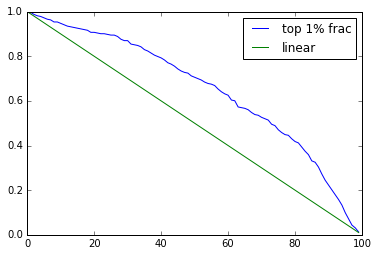

In [92]:
rrr = []
for i in range(100):
    fraction = i/100.0
    there = int(output_pd.sort_values("cumulative_downloads_2016_02",ascending=False)["cumulative_downloads_2016_02"].iloc[int(1.0*len(output_pd)/100)])
    ppp = output_pd
    ppp["is_top"] = (ppp["cumulative_downloads_2016_02"] > there).astype(int)
    rrr.append(sum(ppp[int(fraction*len(ppp)):]['is_top'])*1.0/sum(ppp['is_top']))
    print ".",
plt.plot(range(100),1-rrr,label="top 1% frac")
plt.plot(range(100), np.asarray(range(100))*1.0/100,label="linear")
plt.legend(loc  = 'best')


323

0.47058823529411764

In [ ]:
64.0625
67.1875
70.3125
64.0625
71.875
Top10%              : 99.6875
Top1% with classif1 : 67.5
    
    
    20 + 1
65.625
67.1875
70.3125
64.0625
71.875
Top10%              : 91.25
Top1% with classif1 : 67.8125    

In [ ]:
print len(estimate_top1)
print len(test)
print len(output_test_top_1_precent)
estimate_top1.merge(output_test_top_1_precent, how='inner', on=["id","device"])

In [ ]:
len(estimate_top1.merge(output_test_top_1_precent, how='inner', on=["id","device"]))
print 46.0/64

In [ ]:
metric(y_pred_2,test_output)
1.0*len(inter)/len(lst)

percent = 1
top = int(len(y_pred_2)/100.0*percent)
print (len(set([i[0] for i in sorted(enumerate(y_pred_2), key=lambda x:x[1],reverse=True)][0:top])
   .intersection([i[0] for i in sorted(enumerate(test_output), key=lambda x:x[1],reverse=True)][0:top])
           ))*1.0/(percent/100.0)/top

print len(set([i[0] for i in sorted(enumerate(y_pred_2), key=lambda x:x[1],reverse=True)][0:top]))
print len([i[0] for i in sorted(enumerate(test_output), key=lambda x:x[1],reverse=True)][0:top])
print (len(set([i[0] for i in sorted(enumerate(y_pred_2), key=lambda x:x[1],reverse=True)][0:top])
   .intersection([i[0] for i in sorted(enumerate(test_output), key=lambda x:x[1],reverse=True)][0:top])
           ))/64.0
print (1.0/(1.0/100.0)/len(y_pred_2)*100)

In [ ]:
inter = []
for x in [str(y[0])+str(y[1]) for y in lst_true]:
    if x in [str(y[0])+str(y[1]) for y in lst]:
        inter.append( x)
print len(inter)

In [ ]:
thres = sorted(y_pred_2,reverse=True)[int(len(test)*1.0/100)]
lst= []
for x in enumerate(y_pred_2):
    if x[1]>thres:
        lst.append( predictors_id[test[x[0]]])
        
thres = sorted(test_output,reverse=True)[int(len(test)*1.0/100)]
lst_true= []
for x in enumerate(test_output):
    if x[1]>thres:
        lst_true.append( predictors_id[test[x[0]]])


In [ ]:
import random

best_performance = 0
best_pred_lst = []
for i in range(100):
    thr = random.random()
    pred_lst = filter(lambda x: random.random()>thr , numerical_predictors)
    kf = KFold(len(predictors_pd), n_folds=K,shuffle=False)
    new_top = []
    for train, test in kf:
        train_features = predictors_pd[pred_lst].as_matrix()[train,:]
        train_output = output_pd[["cumulative_downloads_2016_02"]].as_matrix()[train,0]
        test_features = predictors_pd[pred_lst].as_matrix()[test,:]
        test_output = output_pd[["cumulative_downloads_2016_02"]].as_matrix()[test,0]

        mod_top1 = GradientBoostingRegressor(max_features =1.0 ,n_estimators=100, learning_rate=0.1,max_depth=2, random_state=0, loss='ls')\
        .fit(train_features,np.log(train_output))

        y_pred =  mod_top1.predict(test_features)
        estimation_error = metric(y_pred,test_output)
        new_top.append(estimation_error)
    perf = 1.0*sum(new_top)/len(new_top)
    print i
    if perf>best_performance:
        best_pred_lst= pred_lst
        best_performance = perf
        print best_performance
        print pred_lst
